In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from matplotlib import cm

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import plotting
from src.utils import combine_prediction_files, compute_network_avg_prediction

Low Corr Features: ['amp_ratio_1', 'amp_ratio_2', 'amp_ratio_3', 'amp_ratio_18',
      **'amp_1'**, 'amp_18', 'signal_dominant_frequency',
       'noise_max_amplitude', **'source_depth_km'**,
       **'source_receiver_distance_logkm'**,
       **'source_receiver_back_azimuth_deg'**]

Selected Features: [**'amp_1'**,
                    'amp_2',
                    'signal_variance',
                    'noise_variance',
                    **'source_depth_km'**,
                    **'source_receiver_distance_logkm'**,
                    **'source_receiver_back_azimuth_deg'**]

# Load in the necessary data

## The model results summaries

In [2]:
datadir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes'
lowcorr_feat_dir = os.path.join(datadir, 'p_models', 'lowCorrFeatures_constHP')
results_df = pd.read_csv(os.path.join(lowcorr_feat_dir, 'all.stat.results.csv'))
results_rfecvfeats_df = pd.read_csv(os.path.join(datadir, 'p_models','selected_features_constHP', 'all.stat.results.csv'))

In [3]:
results_df.head()

,train_r2,train_rmse,test_r2,test_rmse,holdout_r2,holdout_rmse,station,phase
0,0.924,0.156,0.882,0.195,0.862,0.221,YHB,P
1,0.896,0.182,0.824,0.238,-3.153,0.996,YDC,P
2,0.938,0.142,0.892,0.190,0.879,0.206,YWB,P
3,0.924,0.154,0.887,0.192,0.858,0.208,MCID,P
4,0.930,0.148,0.901,0.175,0.898,0.190,YHL,P


## The example counts

In [4]:
## READ IN DF FOR COUNTS ##
split_cnts = pd.read_csv(os.path.join(datadir, 'feature_splits', 'p.station.ex.counts.csv'))
df_2023 = pd.read_csv(os.path.join(datadir, 'feature_splits', 'p.20230101.csv'))
split_cnts.head()

,station,cnt_train,cnt_test,cnt_holdout
0,YHH,4813,1215.0,397.0
1,YNR,4649,1174.0,275.0
2,YMC,4322,1110.0,460.0
3,YMR,4154,1071.0,446.0
4,YPM,4078,1018.0,438.0


## The model predictions

In [5]:
all_stats = results_df['station']
train_preds_df = combine_prediction_files(all_stats, lowcorr_feat_dir,'P', 'train')
test_preds_df = combine_prediction_files(all_stats, lowcorr_feat_dir,'P', 'test')
train_preds_df

,Evid,magnitude,predicted_magnitude,station
0,60000622,0.694976,0.584601,YHB
1,60001352,2.250510,2.098541,YHB
2,60001367,2.155231,2.091551,YHB
3,60001392,2.076413,1.673755,YHB
4,60001397,2.273901,2.068705,YHB
...,...,...,...,...
588,60456897,2.121661,2.403577,YDD
589,60456907,3.098341,3.131984,YDD
590,60470442,1.697778,1.390626,YDD
591,60513762,1.051296,0.951194,YDD


In [6]:
holdout_preds_df = combine_prediction_files(df_2023['station'].unique(), lowcorr_feat_dir,'P', 'holdout')
holdout_preds_df

,Evid,magnitude,predicted_magnitude,station
0,60528982,1.363650,1.340363,YHH
1,60529052,1.338398,1.058637,YHH
2,60529182,2.608960,1.997503,YHH
3,60529562,0.843194,1.076309,YHH
4,60529752,1.289612,1.534222,YHH
...,...,...,...,...
14,60554577,1.558406,1.832365,FLWY
15,60556087,1.402305,1.151634,FLWY
16,60556132,1.403297,1.786659,FLWY
17,60556617,1.858090,1.789139,FLWY


In [7]:
# Filter split counts to only stats with models
split_cnts = split_cnts[split_cnts['station'].isin(all_stats)]

# Look at the scores from various splits

In [8]:
results_df['train_r2'].describe()

count    35.000000
mean      0.929971
std       0.017352
min       0.889000
25%       0.921500
50%       0.929000
75%       0.941500
max       0.961000
Name: train_r2, dtype: float64

In [9]:
results_df['test_r2'].describe()

count    35.000000
mean      0.869257
std       0.034076
min       0.785000
25%       0.855500
50%       0.877000
75%       0.892000
max       0.936000
Name: test_r2, dtype: float64

In [10]:
results_df['holdout_r2'].describe()

count    29.000000
mean      0.637897
std       0.741558
min      -3.153000
25%       0.755000
50%       0.805000
75%       0.858000
max       0.908000
Name: holdout_r2, dtype: float64

In [11]:
(test_preds_df['magnitude'] - test_preds_df['predicted_magnitude']).describe()

count    16531.000000
mean         0.011711
std          0.198827
min         -1.171501
25%         -0.111455
50%          0.010168
75%          0.127045
max          1.303130
dtype: float64

In [12]:
(holdout_preds_df['magnitude'] - holdout_preds_df['predicted_magnitude']).describe()

count    5861.000000
mean        0.019381
std         0.247723
min        -1.424833
25%        -0.126746
50%         0.016752
75%         0.167131
max         1.518626
dtype: float64

# Make tables/heatmaps to compare the scores

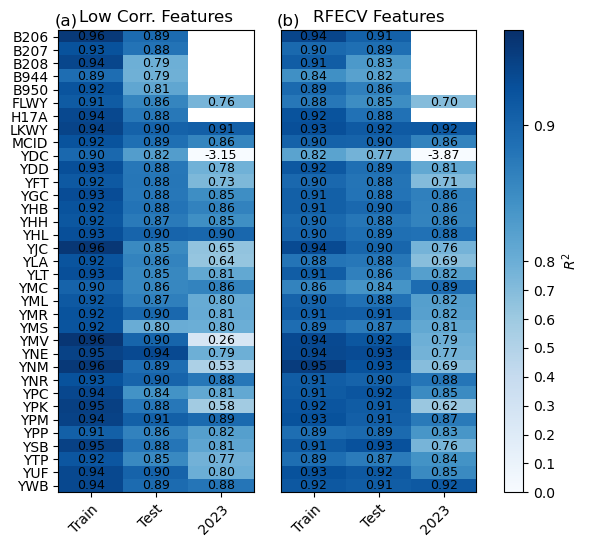

In [37]:
fig, axes = plt.subplots(1, 3, width_ratios=[2, 2, 0.2], figsize=(6, 6))

midpoint_normalize = True
midpoint = 0.8
cmap_min = 0
cmap_max = 0.97
xlabels=['Train', 'Test', '2023']

im1 = plotting.scores_heatmap(results_df.sort_values('station'),
                        midpoint_normalize=midpoint_normalize,
                        midpoint=midpoint,
                        cmap_min=cmap_min,
                        cmap_max=cmap_max,
                        title='Low Corr. Features',
                        ax=axes[0],
                        show_ylabels=True,
                        show_cbar=False,
                        xticklabels=xlabels,
                        tablefontsize=9)
im2 = plotting.scores_heatmap(results_rfecvfeats_df.sort_values('station'),
                        midpoint_normalize=midpoint_normalize,
                        midpoint=midpoint,
                        cmap_min=cmap_min,
                        cmap_max=cmap_max,
                        title='RFECV Features',
                        ax=axes[1],
                        show_ylabels=False,
                        show_cbar=False,
                        xticklabels=xlabels,
                        tablefontsize=9)
plt.colorbar(im2, cax=axes[2], label=f'$R^2$', ticks=np.arange(0, 1.0, 0.1))

sp_labels = ['(a)', '(b)']
for i, ax in enumerate(axes[:-1]):
    ax.text(-0.02, 
            1.01, 
            sp_labels[i], 
            transform=ax.transAxes,
            fontsize=12)
    
#fig.tight_layout()
fig.show()

cmap midpoint set to 397.0
cmap min set to 8.0
cmap max set to 4813.0
cmap min set to -0.53
cmap max set to 0.7130000000000001


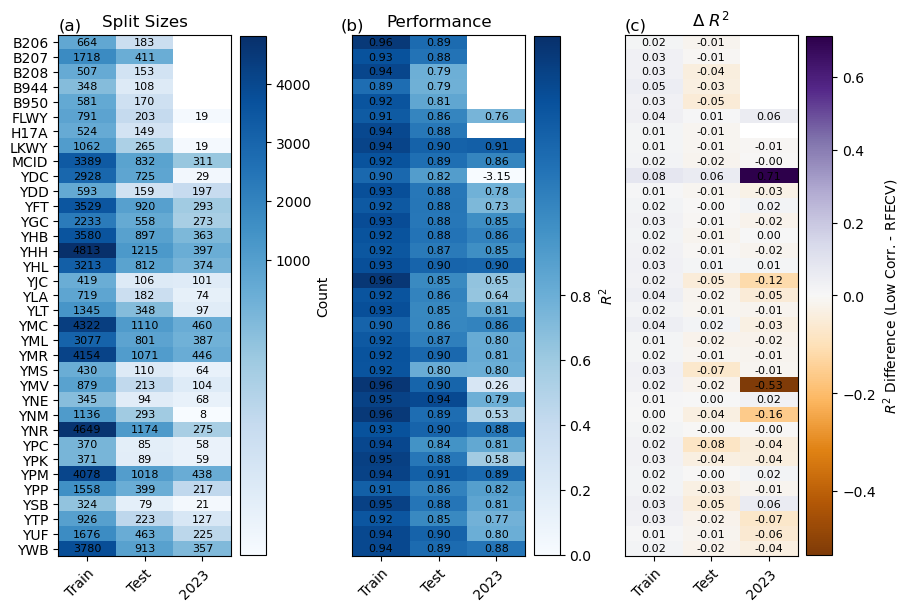

In [38]:
diff_df = results_df.sort_values('station')[['train_r2', 'test_r2', 'holdout_r2']] - results_rfecvfeats_df.sort_values('station')[['train_r2', 'test_r2', 'holdout_r2']]
diff_df['station'] = results_df.sort_values('station')['station']
fig, axes = plt.subplots(1, 3, figsize=(9, 6), constrained_layout=True) #, width_ratios=[2, 2, 0.2], figsize=(6, 6))

im1 = plotting.scores_heatmap(split_cnts.sort_values('station'),
                        ax=axes[0],
                        cols=['cnt_train', 'cnt_test', 'cnt_holdout'],
                        midpoint_normalize=True,
                        midpoint=None,
                        title='Split Sizes',
                        show_ylabels=True,
                        show_cbar=True,
                        xticklabels=xlabels,
                        cbar_label=f'Count',
                        cmap=cm.Blues,
                        tablefontcolor='k',
                        tablefontsize=8,
                        tight_layout=True,
                        tablevalueprec=0)

im1 = plotting.scores_heatmap(results_df.sort_values('station'),
                        midpoint_normalize=midpoint_normalize,
                        midpoint=midpoint,
                        cmap_min=cmap_min,
                        cmap_max=cmap_max,
                        title='Performance',
                        ax=axes[1],
                        show_ylabels=False,
                        show_cbar=True,
                        xticklabels=xlabels,
                        tablefontsize=8,
                        cbar_label=f'$R^2$')

im3 = plotting.scores_heatmap(diff_df,
                             ax = axes[2],
                            midpoint_normalize=True,
                            midpoint=0,
                            cmap_max = None,
                            cmap_min = None,
                            title='$\Delta$ $R^2$',
                            show_ylabels=False,
                            show_cbar=True,
                            xticklabels=xlabels,
                            cbar_label=f'$R^2$ Difference (Low Corr. - RFECV)',
                            cmap=cm.PuOr,
                            tablefontcolor='k',
                            tablefontsize=8,
                            tight_layout=True,
                            )

sp_labels = ['(a)', '(b)', '(c)']
sp_label_x = [ 0,-0.07, 0]
for i, ax in enumerate(axes):
    ax.text(sp_label_x[i], 
            1.01, 
            sp_labels[i], 
            transform=ax.transAxes,
            fontsize=12)
    
#fig.tight_layout()

# Actual vs predicted plots

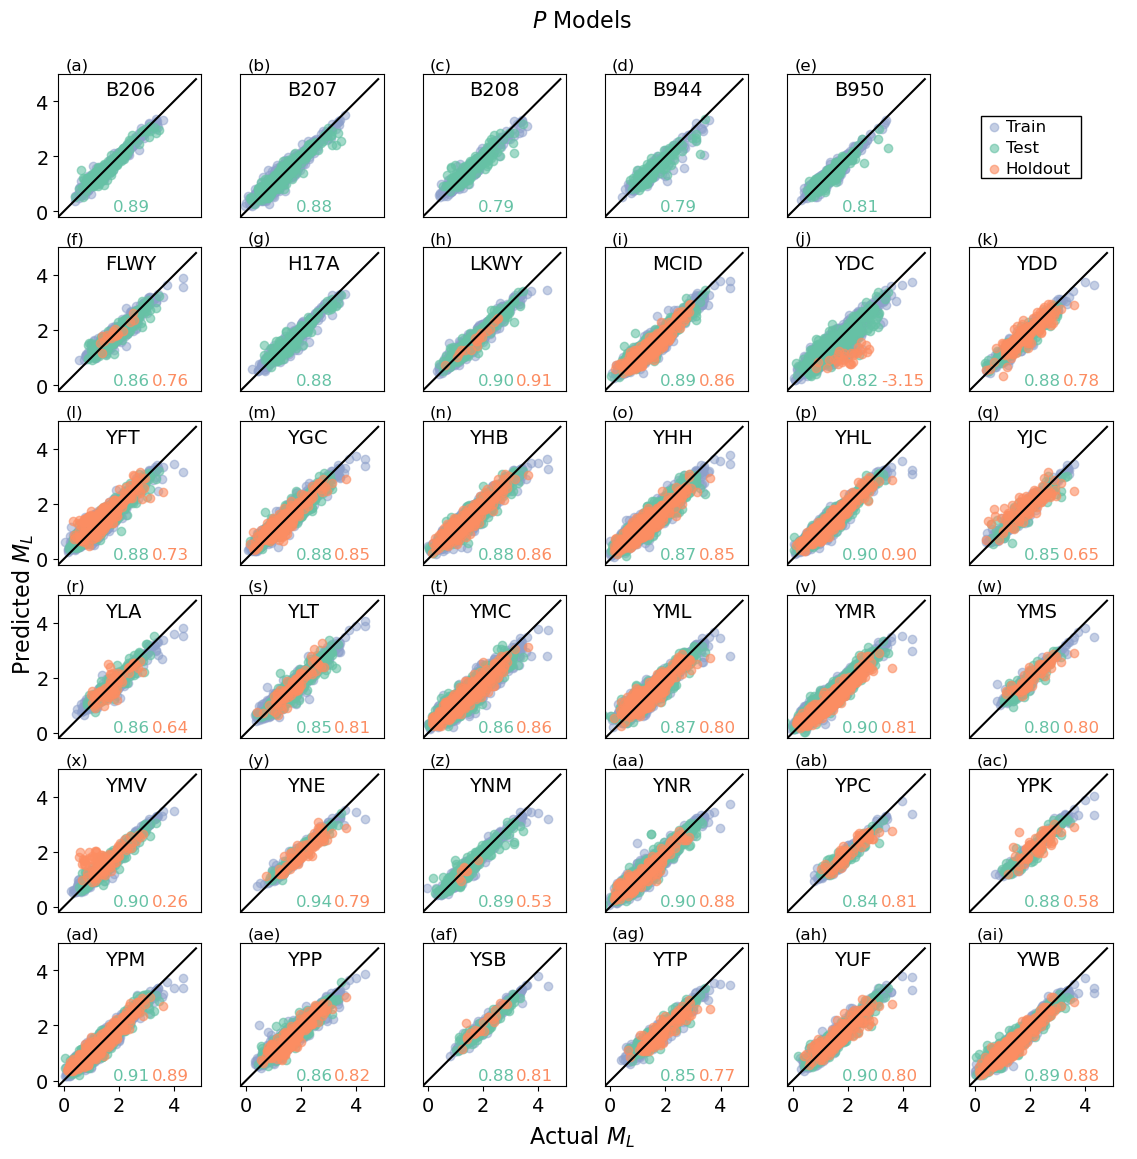

In [15]:
plotting.actual_v_predicted(results_df,
                     train_preds_df, 
                     test_preds_df,
                     holdout_preds_df,
                     inner_ticks_on=False,
                     title='$\it P$ Models',
                     colors=['#8da0cb', '#66c2a5', '#fc8d62'],
                     alphas=[0.5, 0.6, 0.6],
                     linestyle='-',
                     n_cols=6)

# Average the predictions

In [16]:
test_avg_df = compute_network_avg_prediction(test_preds_df)
holdout_avg_df = compute_network_avg_prediction(holdout_preds_df)

In [17]:
(test_avg_df['magnitude'] - test_avg_df['predicted_magnitude']).describe()

count    1498.000000
mean       -0.002851
std         0.133239
min        -0.665892
25%        -0.079690
50%        -0.000078
75%         0.076265
max         0.659528
dtype: float64

In [18]:
(holdout_avg_df['magnitude'] - holdout_avg_df['predicted_magnitude']).describe()

count    508.000000
mean       0.003348
std        0.149674
min       -0.423321
25%       -0.090606
50%        0.012876
75%        0.098338
max        0.823743
dtype: float64

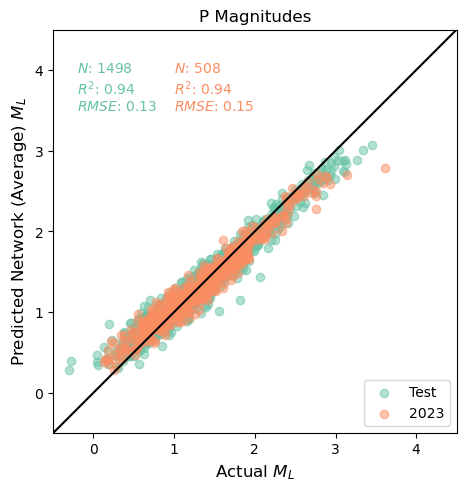

In [19]:
plotting.actual_v_network_avg_prediction([test_avg_df, holdout_avg_df],
                                    title='P Magnitudes',
                                    plot_lims=[-0.5, 4.5],
                                    alphas=[0.5, 0.5],
                                    legend_labels=['Test', '2023'],
                                    plot_legend=True,
                                    marker_colors=['#66c2a5', '#fc8d62'],
                                    text_x = [-0.2, 0.0],
                                    text_y=[-1.0, -1.0])

In [20]:
train_preds_df.iloc[train_preds_df['magnitude'].argmax()]

Evid                   60497322
magnitude              4.332082
predicted_magnitude    3.280234
station                     YHB
Name: 3146, dtype: object

In [21]:
holdout_preds_df.iloc[holdout_preds_df['magnitude'].argmax()]

Evid                   60535541
magnitude              3.615056
predicted_magnitude    2.937976
station                     YHH
Name: 92, dtype: object

In [22]:
test_preds_df.iloc[test_preds_df['magnitude'].argmax()]

Evid                   60071202
magnitude              3.446631
predicted_magnitude    3.186502
station                     YHB
Name: 229, dtype: object

# Average predictions when using all features

In [23]:
diff_df['train_r2'].describe()[['50%', 'std']]

50%    0.024000
std    0.013761
Name: train_r2, dtype: float64

In [24]:
diff_df['test_r2'].describe()[['50%', 'std']]

50%   -0.014000
std    0.025325
Name: test_r2, dtype: float64

In [25]:
diff_df['holdout_r2'].describe()[['50%', 'std']]

50%   -0.015000
std    0.174231
Name: holdout_r2, dtype: float64

In [26]:
results_rfecvfeats_df['train_r2'].describe()[['min', 'max', '50%']]

min    0.817
max    0.954
50%    0.909
Name: train_r2, dtype: float64

In [27]:
results_rfecvfeats_df['test_r2'].describe()[['min', 'max', '50%']]

min    0.766
max    0.934
50%    0.887
Name: test_r2, dtype: float64

In [28]:
results_rfecvfeats_df['holdout_r2'].describe()[['min', 'max', '50%']]

min   -3.866
max    0.916
50%    0.822
Name: holdout_r2, dtype: float64

In [29]:
all_stats = results_df['station']
pred_path = os.path.join(datadir,'p_models', 'all_features')
train_preds_allfeat_df = combine_prediction_files(all_stats, pred_path,'P', 'train')
test_preds_allfeat_df = combine_prediction_files(all_stats, pred_path,'P', 'test')
holdout_preds_allfeat_df = combine_prediction_files(df_2023['station'].unique(), pred_path,'P', 'holdout')


In [30]:
(test_preds_allfeat_df['magnitude'] - test_preds_allfeat_df['predicted_magnitude']).describe()[['50%', 'std']]

50%    0.010043
std    0.205939
dtype: float64

In [31]:
(holdout_preds_allfeat_df['magnitude'] - holdout_preds_allfeat_df['predicted_magnitude']).describe()[['50%', 'std']]

50%    0.015674
std    0.250501
dtype: float64

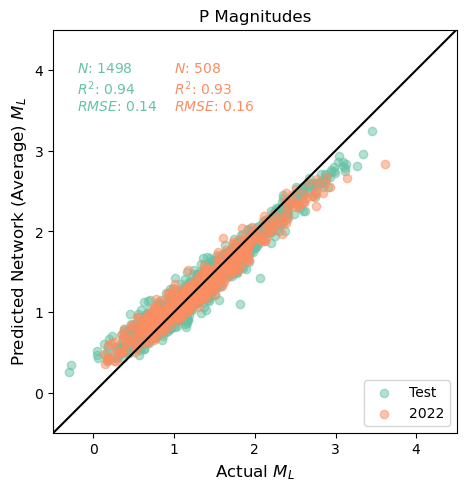

In [32]:
test_avg_allfeat_df = compute_network_avg_prediction(test_preds_allfeat_df)
holdout_avg_allfeat_df = compute_network_avg_prediction(holdout_preds_allfeat_df)
plotting.actual_v_network_avg_prediction([test_avg_allfeat_df, holdout_avg_allfeat_df],
                                    title='P Magnitudes',
                                    plot_lims=[-0.5, 4.5],
                                    alphas=[0.5, 0.5],
                                    legend_labels=['Test', '2022'],
                                    plot_legend=True,
                                    marker_colors=['#66c2a5', '#fc8d62'],
                                    text_x = [-0.2, 0.0],
                                    text_y=[-1.0, -1.0])

In [33]:
(test_avg_allfeat_df['magnitude'] - test_avg_allfeat_df['predicted_magnitude']).describe()[['50%', 'std']]

50%    0.004793
std    0.140425
dtype: float64

In [34]:
(holdout_avg_allfeat_df['magnitude'] - holdout_avg_allfeat_df['predicted_magnitude']).describe()[['50%', 'std']]

50%    0.011869
std    0.160374
dtype: float64

(-1.1, 1.1)

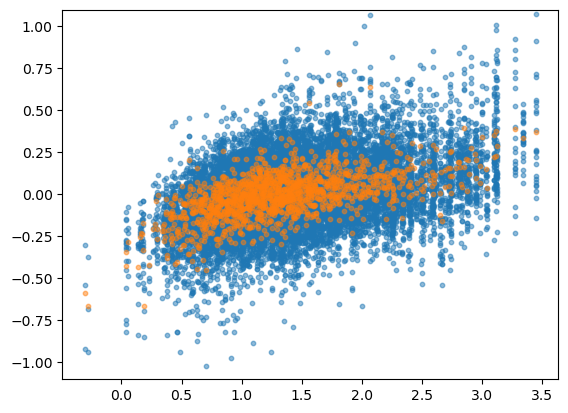

In [35]:
plt.scatter(test_preds_df['magnitude'], 
            test_preds_df['magnitude'] - test_preds_df['predicted_magnitude'],
            alpha=0.5,
            s=10)
plt.scatter(test_avg_df['magnitude'], 
            test_avg_df['magnitude'] - test_avg_df['predicted_magnitude'],
            alpha=0.5,
            s=10)
plt.ylim([-1.1, 1.1])

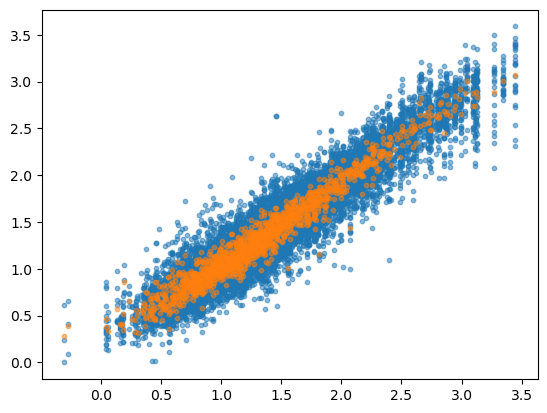

In [36]:
plt.scatter(test_preds_df['magnitude'], 
            test_preds_df['predicted_magnitude'],
            alpha=0.5,
            s=10)
plt.scatter(test_avg_df['magnitude'], 
            test_avg_df['predicted_magnitude'],
            alpha=0.5,
            s=10)